In [1]:
import torch
import matplotlib.pyplot as plt
from random import randint
import cv2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
#Criando o gerador de fundo preto:
#Localization vai ser (x1,y1, width, height)
def img_generator(batch_size=16):
    while True:
        background = torch.zeros((batch_size,3,100,100))
        localization = torch.zeros((batch_size,4))
        #Criando o gerador de quadrado branco

        for i in range(batch_size):
            x1 = randint(0,(background.shape[2]-10))
            x2 = randint(x1, (background.shape[2]))
            y1 = randint(0,(background.shape[3]-10))
            y2 = randint(y1, (background.shape[3]))
            background[i,:,x1:x2,y1:y2] = 1
            localization[i,0] = x1/background.shape[2]
            localization[i,1] = y1/background.shape[2]
            localization[i,2] = (x2-x1)/background.shape[3]
            localization[i,3] = (y2-y1)/background.shape[3]

        yield background,localization

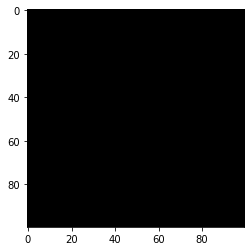

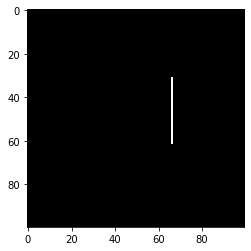

In [3]:
#Instanciando o gerador
generator = img_generator()
valid_generator = img_generator()
for i,j in generator:
    plt.imshow(i[0].permute(1,2,0))
    plt.show()
    for r,t in valid_generator:
        plt.imshow(r[0].permute(1,2,0))
        plt.show()
       
        break
    break

In [4]:
#Criando a rede neural
import torchvision.models as models
import torch.nn as nn
from torchsummary import summary

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 4), nn.Sigmoid())
model.to(device)
summary(model, input_size=(3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           9,408
       BatchNorm2d-2           [-1, 64, 50, 50]             128
              ReLU-3           [-1, 64, 50, 50]               0
         MaxPool2d-4           [-1, 64, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]           4,096
       BatchNorm2d-6           [-1, 64, 25, 25]             128
              ReLU-7           [-1, 64, 25, 25]               0
            Conv2d-8           [-1, 64, 25, 25]          36,864
       BatchNorm2d-9           [-1, 64, 25, 25]             128
             ReLU-10           [-1, 64, 25, 25]               0
           Conv2d-11          [-1, 256, 25, 25]          16,384
      BatchNorm2d-12          [-1, 256, 25, 25]             512
           Conv2d-13          [-1, 256, 25, 25]          16,384
      BatchNorm2d-14          [-1, 256,

In [5]:
from torch.optim import lr_scheduler
#Criando um optimizer para apenas a ÚLTIMA layer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Criando a loss function
loss_function = nn.BCELoss()

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [6]:
import time
import os
from tqdm import tqdm

val_cont = 0
train_loss = 0


val_loss = 0.0
i = 0
l = 0

MODEL_NAME = f"model-{int(time.time())}"
EPOCHS = 50
best = 90000.0
with open("model.log", "a") as f: 
    for epoch in range(EPOCHS):

        i=0
        for data,target in tqdm(generator):
            data, target = data.to(device), target.to(device)
            #print(f"\n\n {data.shape}")
            model.zero_grad()
            output = model(data)
            print(f"\nOutput: {output} Target: {target}")
            loss = loss_function(output,target)

        
            loss.backward()
            optimizer.step()

            #Estatística da rede neural
            #train_loss += loss.item() * data.size(0)
            i += 1
            if i == 10:
                break
            '''if i % 10 ==0:'''
        with torch.no_grad():
            for val_data, val_target in valid_generator:
                val_data, val_target = val_data.to(device), val_target.to(device)

                model.zero_grad()
                val_out = model(val_data)

                val_loss += loss_function(val_out,val_target).item() * val_data.size(0)


                l += len(val_target)
                break
        v_loss = val_loss / l
        #print(v_loss)
        if v_loss<best:
            best = v_loss
            torch.save(model, os.path.join(os.getcwd(),'model_Black_Box.pth'))
        f.write(f"{MODEL_NAME}, {round(time.time(),3)},  {round(float(v_loss),2)}\n")
        #exp_lr_scheduler.step()


0it [00:00, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.00 GiB total capacity; 639.08 MiB already allocated; 19.81 MiB free; 668.00 MiB reserved in total by PyTorch)

In [7]:
import cv2 
import matplotlib.patches as patches
model = torch.load(os.path.join(os.getcwd(), 'model_Black_Box.pth'))

model.to(device)
model.eval()


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.00 GiB total capacity; 648.86 MiB already allocated; 15.81 MiB free; 672.00 MiB reserved in total by PyTorch)

In [8]:
background = torch.zeros((3,100,100))
x1 = randint(0,(background.shape[1]-10))
x2 = randint(x1, (background.shape[1]))
y1 = randint(0,(background.shape[2]-10))
y2 = randint(y1, (background.shape[2]))
background[:,x1:x2,y1:y2] = 1
input = background.unsqueeze(0)

input = input.to(device)
out = model(input)
out = out.reshape(4)
print(out.shape)
fig,ax = plt.subplots(1)
ax.imshow(background.permute(1,2,0))
rect = patches.Rectangle((out[1]*100,out[0]*100),out[3]*100,out[2]*100,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 2.00 GiB total capacity; 663.92 MiB already allocated; 1.81 MiB free; 686.00 MiB reserved in total by PyTorch)